In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport
from xgboost import XGBClassifier
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

# Data loading and inspection

In [3]:
df = pd.read_csv("C:/Users/argon/Documents/Desktop Prime/MS Business Analytics/Fall Semester/Marketing Analytics/Modified_Telco_Customer_Churn_Updated.csv")
df.head()

prof = ProfileReport(df)
prof


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df = df[~np.isinf(df['AvgChargesPerMonth'])]
df.Churn.value_counts()
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0}).astype(int)

C:\Users\argon\AppData\Local\Temp\ipykernel_4996\3107498847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0}).astype(int)


# Initial Visualizations on Churn

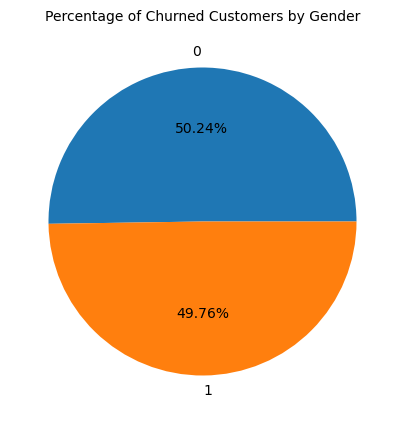

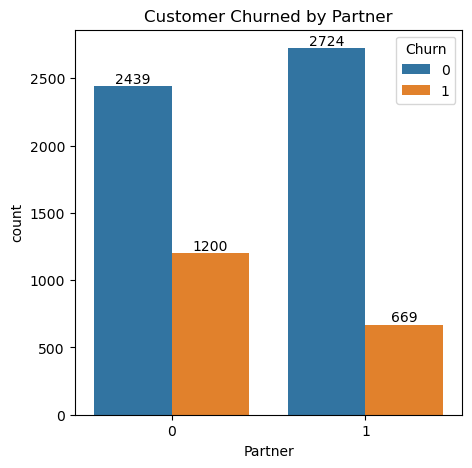

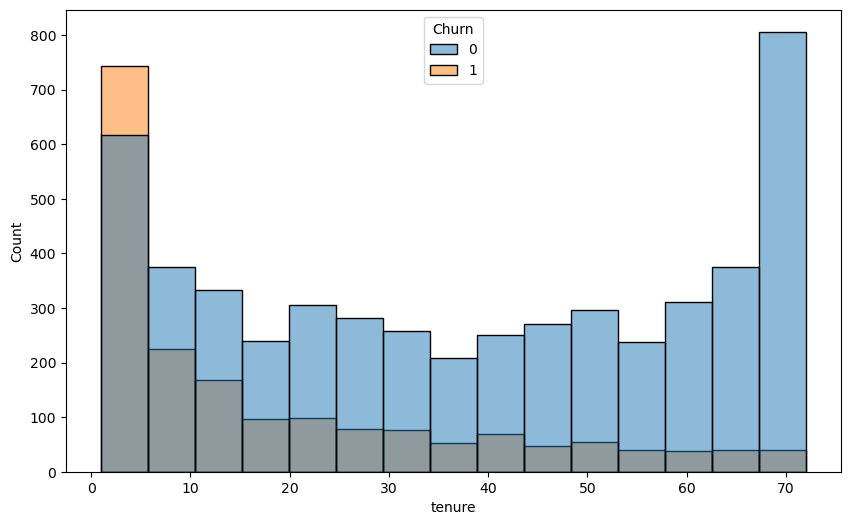

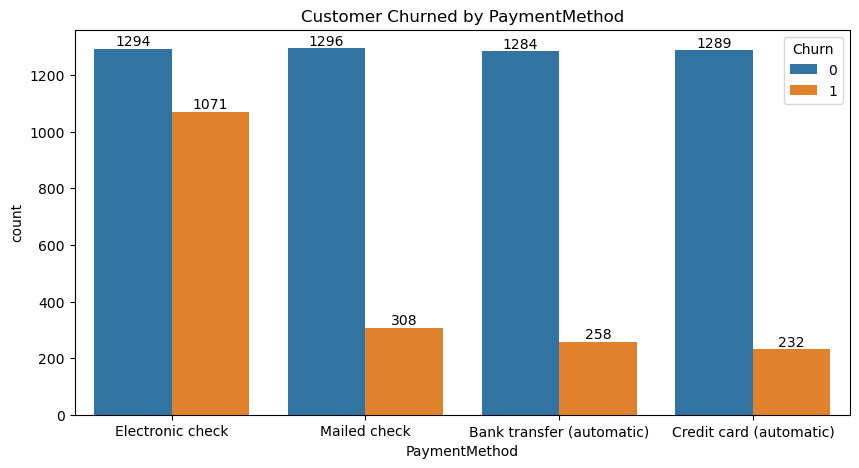

In [7]:
# Pie chart of churned customers by gender
churned_customers = df[df['Churn'] == 1]
gender_counts = churned_customers['gender'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.2f%%")
plt.title("Percentage of Churned Customers by Gender", fontsize=10)
plt.show()

# Countplot of churn by partner status
plt.figure(figsize=(5, 5))
plt.title('Customer Churned by Partner')
ax = sns.countplot(x='Partner', data=df, hue='Churn')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# Histogram of tenure segmented by churn
plt.figure(figsize=(10, 6))
sns.histplot(x='tenure', data=df, hue='Churn')
plt.show()

# Countplot of churn by payment method
plt.figure(figsize=(10, 5))
plt.title('Customer Churned by PaymentMethod')
ax = sns.countplot(x='PaymentMethod', data=df, hue='Churn')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# Feature Distribution Exploration

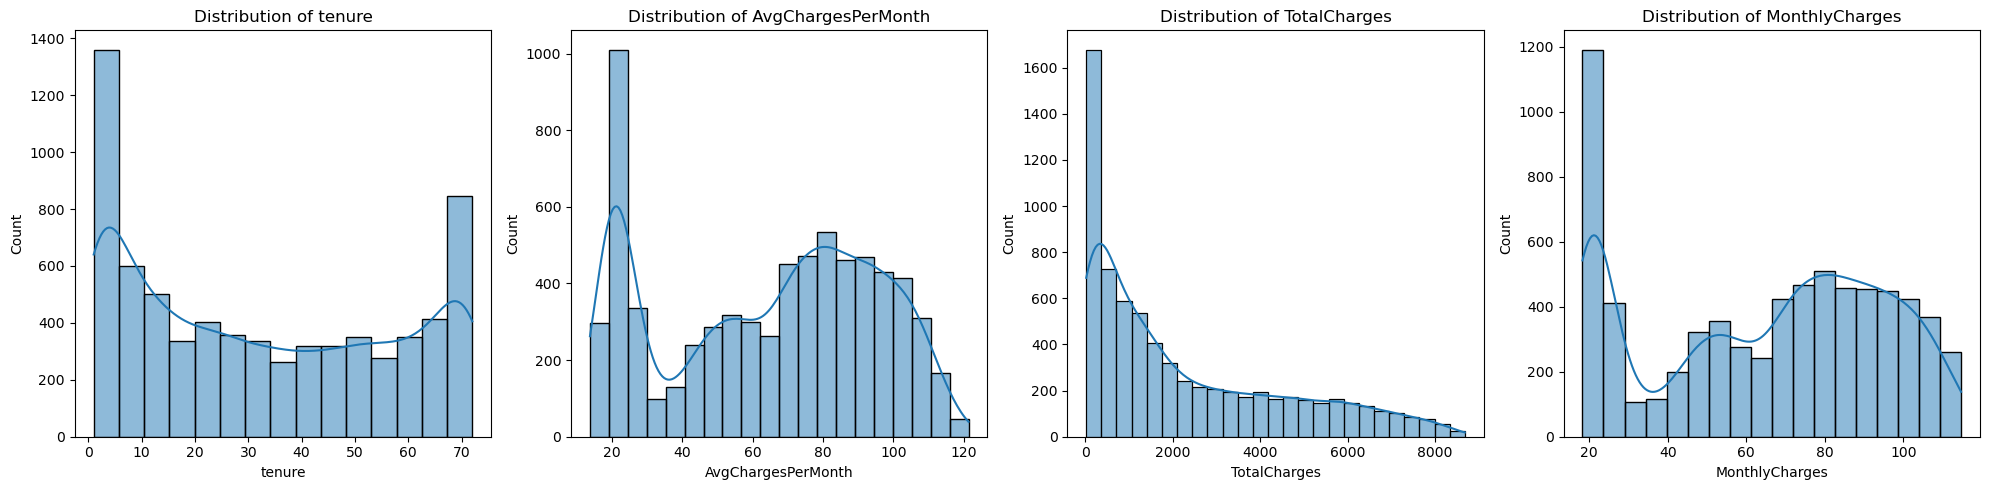

In [8]:
# Distribution plots of numerical variables
numerical_vars = ['tenure', 'AvgChargesPerMonth', 'TotalCharges', 'MonthlyCharges']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, var in enumerate(numerical_vars):
    sns.histplot(df[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

# Feature Engineering

C:\Users\argon\AppData\Local\Temp\ipykernel_4996\1033356752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLV'] = df['tenure'] * df['MonthlyCharges']


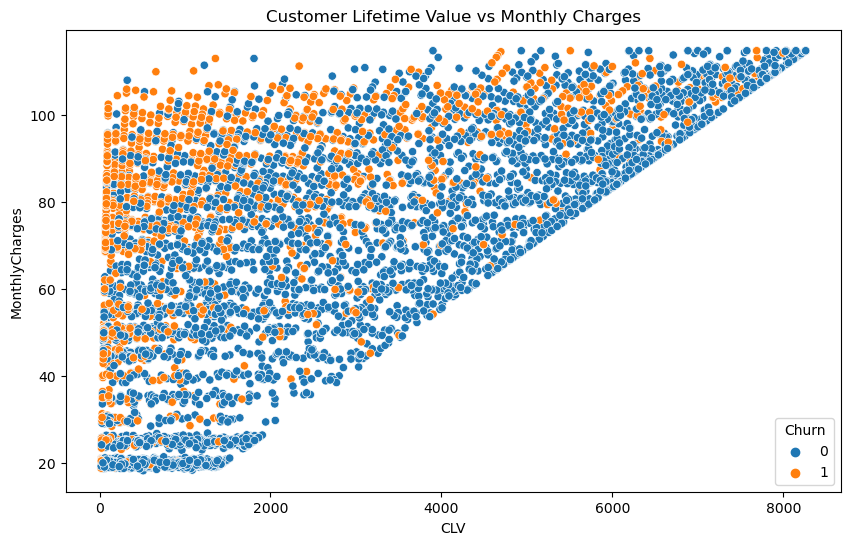

C:\Users\argon\AppData\Local\Temp\ipykernel_4996\1033356752.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TenureBin'] = pd.cut(df['tenure'],
C:\Users\argon\AppData\Local\Temp\ipykernel_4996\1033356752.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalServices'] = df[services].notnull().sum(axis=1)
C:\Users\argon\AppData\Local\Temp\ipykernel_4996\1033356752.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [9]:
# Create CLV (Customer Lifetime Value)
df['CLV'] = df['tenure'] * df['MonthlyCharges']

# Scatter plot of CLV vs Monthly Charges
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CLV', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Customer Lifetime Value vs Monthly Charges')
plt.show()

# Bin tenure and compute average CLV by bin
df['TenureBin'] = pd.cut(df['tenure'], 
                         bins=[0, 12, 24, 36, 48, 60, np.inf], 
                         labels=['0-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5+ Years'])
services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = df[services].notnull().sum(axis=1)
df['AvgCLVbyTenureBin'] = df.groupby('TenureBin')['CLV'].transform('mean')


# Encoding Categorical Variables

In [10]:
# Label encode binary variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
df[binary_cols] = df[binary_cols].apply(lambda x: LabelEncoder().fit_transform(x))

# Target encoding based on churn rate
for col in ['Contract', 'PaymentMethod', 'InternetService']:
    target_mean = df.groupby(col)['Churn'].mean()
    df[f'{col}_churn_encoded'] = df[col].map(target_mean)

C:\Users\argon\AppData\Local\Temp\ipykernel_4996\1890507868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binary_cols] = df[binary_cols].apply(lambda x: LabelEncoder().fit_transform(x))
C:\Users\argon\AppData\Local\Temp\ipykernel_4996\1890507868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_churn_encoded'] = df[col].map(target_mean)
C:\Users\argon\AppData\Local\Temp\ipykernel_4996\1890507868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

# Clustering Pipeline

C:\Users\argon\AppData\Local\Temp\ipykernel_4996\2267729548.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TenureBin'] = df['TenureBin'].fillna(df['TenureBin'].mode()[0])
C:\Users\argon\AppData\Local\Temp\ipykernel_4996\2267729548.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AvgCLVbyTenureBin'] = df['AvgCLVbyTenureBin'].fillna(df['AvgCLVbyTenureBin'].median())


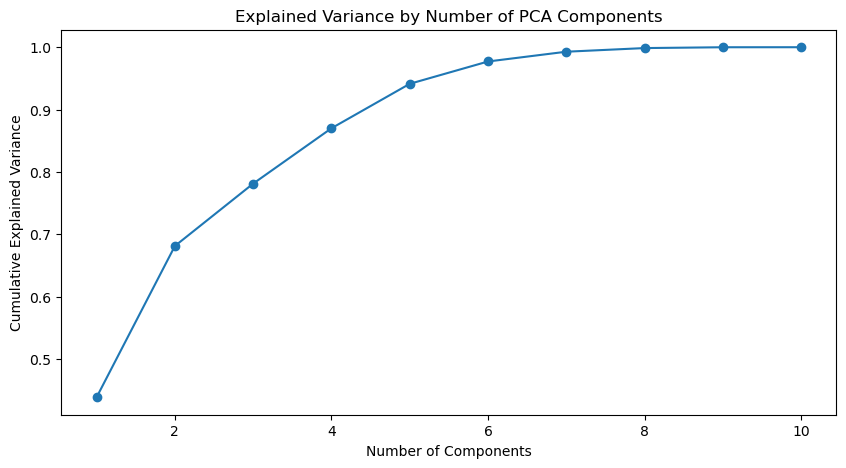

K-Means Silhouette Score: 0.2726


C:\Users\argon\anaconda3\envs\markprojenv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\argon\anaconda3\envs\markprojenv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


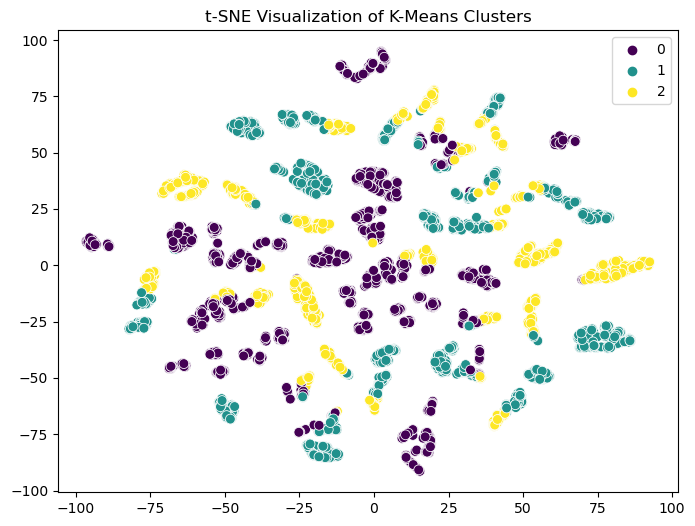

In [11]:
# Prepare features and standardize
features = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'CLV', 'TotalServices',
               'AvgCLVbyTenureBin', 'gender', 'SeniorCitizen'] +
              [f'{col}_churn_encoded' for col in ['Contract', 'PaymentMethod', 'InternetService']]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Handle missing values
df['TenureBin'] = df['TenureBin'].fillna(df['TenureBin'].mode()[0])
df['AvgCLVbyTenureBin'] = df['AvgCLVbyTenureBin'].fillna(df['AvgCLVbyTenureBin'].median())

# PCA for dimensionality reduction
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Explained Variance by Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
print(f"K-Means Silhouette Score: {silhouette_score(X_pca, kmeans_labels):.4f}")

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.show()


# Classification Models per Custer

In [14]:
from sklearn.preprocessing import LabelEncoder

# Ensure Cluster is safely created on the full DataFrame
df = df.copy()
df.loc[:, 'Cluster'] = kmeans.fit_predict(X_scaled)
df.loc[:, 'Cluster'] = df['Cluster'].replace({0: 1, 1: 2, 2: 3})

# Optional safety encoding for any remaining object columns
# Especially if you haven't already done pd.get_dummies() on them
df = df.copy()
for col in df.select_dtypes(include='object').columns:
    if col not in ['customerID']:  # skip ID
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Run classification cluster by cluster
for cluster in sorted(df['Cluster'].unique()):
    print(f"\n--- Cluster {cluster} ---")
    
    cluster_data = df[df['Cluster'] == cluster]
    
    # Drop irrelevant or non-numeric columns
    drop_cols = ['Churn', 'Cluster', 'customerID']
    feature_cols = [col for col in cluster_data.columns if col not in drop_cols]
    
    X = cluster_data[feature_cols]
    y = cluster_data['Churn']
    
    # Ensure X is fully numeric
    X = X.select_dtypes(include=[np.number])
    
    # Handle imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42
    )

    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importances
    feature_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    print("\nVariable Importance:")
    print(feature_importances_df)


--- Cluster 1 ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       713
           1       0.90      0.90      0.90       689

    accuracy                           0.90      1402
   macro avg       0.90      0.90      0.90      1402
weighted avg       0.90      0.90      0.90      1402


Variable Importance:
                          feature  importance
23         Contract_churn_encoded    0.128219
4                          tenure    0.088665
20                            CLV    0.086072
17                   TotalCharges    0.085068
14                       Contract    0.081148
19                 MonthlyCharges    0.077140
18             AvgChargesPerMonth    0.074423
24    PaymentMethod_churn_encoded    0.049488
22              AvgCLVbyTenureBin    0.041940
2                         Partner    0.034930
3                      Dependents    0.029115
16                  PaymentMethod    0.028415
0         

# Hyperparameter Tuning with GridSearchCV

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

for cluster in sorted(df['Cluster'].unique()):
    print(f"\n--- Cluster {cluster} ---")

    cluster_data = df[df['Cluster'] == cluster].copy()

    # Drop non-feature columns
    drop_cols = ['Churn', 'Cluster', 'customerID']
    X = cluster_data.drop(columns=drop_cols, errors='ignore')
    y = cluster_data['Churn']

    # Drop or encode problematic categorical columns
    if 'TenureBin' in X.columns:
        X['TenureBin'] = LabelEncoder().fit_transform(X['TenureBin'].astype(str))

    # Label encode any remaining object (string) columns
    for col in X.select_dtypes(include='object').columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

    # Final check to only keep numeric columns
    X = X.select_dtypes(include=[np.number])

    # SMOTE oversampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42
    )

    # GridSearch with XGBoost
    xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"\nBest parameters for Cluster {cluster}: {grid_search.best_params_}")

    y_pred = best_model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    feature_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    print("\nVariable Importance:")
    print(feature_importances_df)



--- Cluster 1 ---
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\argon\anaconda3\envs\markprojenv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:13] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters for Cluster 1: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       713
           1       0.90      0.90      0.90       689

    accuracy                           0.90      1402
   macro avg       0.90      0.90      0.90      1402
weighted avg       0.90      0.90      0.90      1402


Variable Importance:
                          feature  importance
24         Contract_churn_encoded    0.351850
7                 InternetService    0.119852
3                      Dependents    0.065156
25    PaymentMethod_churn_encoded    0.047113
2                         Partner    0.039665
14                       Contract    0.036734
8                  OnlineSecurity    0.036630
5                    PhoneService    0.036338
4                          tenure    0.029936
0                          gende

C:\Users\argon\anaconda3\envs\markprojenv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:20] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters for Cluster 2: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       364
           1       0.68      0.67      0.67       392

    accuracy                           0.66       756
   macro avg       0.66      0.66      0.66       756
weighted avg       0.66      0.66      0.66       756


Variable Importance:
                          feature  importance
21                      TenureBin    0.230336
4                          tenure    0.077308
26  InternetService_churn_encoded    0.060753
24         Contract_churn_encoded    0.049900
15               PaperlessBilling    0.047674
7                 InternetService    0.047631
6                   MultipleLines    0.045436
13                StreamingMovies    0.035830
1                   SeniorCitizen    0.033251
25    PaymentMethod_churn_encod

C:\Users\argon\anaconda3\envs\markprojenv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:27] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters for Cluster 3: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       546
           1       0.89      0.90      0.90       512

    accuracy                           0.90      1058
   macro avg       0.90      0.90      0.90      1058
weighted avg       0.90      0.90      0.90      1058


Variable Importance:
                          feature  importance
14                       Contract    0.212783
24         Contract_churn_encoded    0.096363
11                    TechSupport    0.086209
8                  OnlineSecurity    0.085777
25    PaymentMethod_churn_encoded    0.074934
3                      Dependents    0.056283
16                  PaymentMethod    0.054913
10               DeviceProtection    0.031888
9                    OnlineBackup    0.027788
2                         Partne

# Cluster-Based Visualization

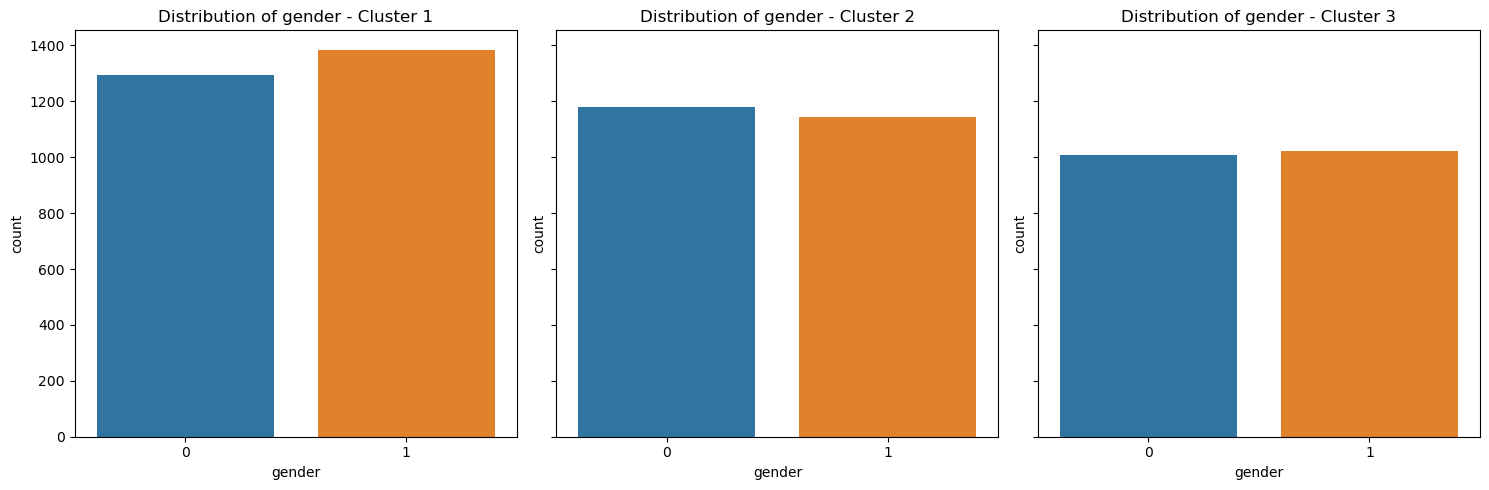

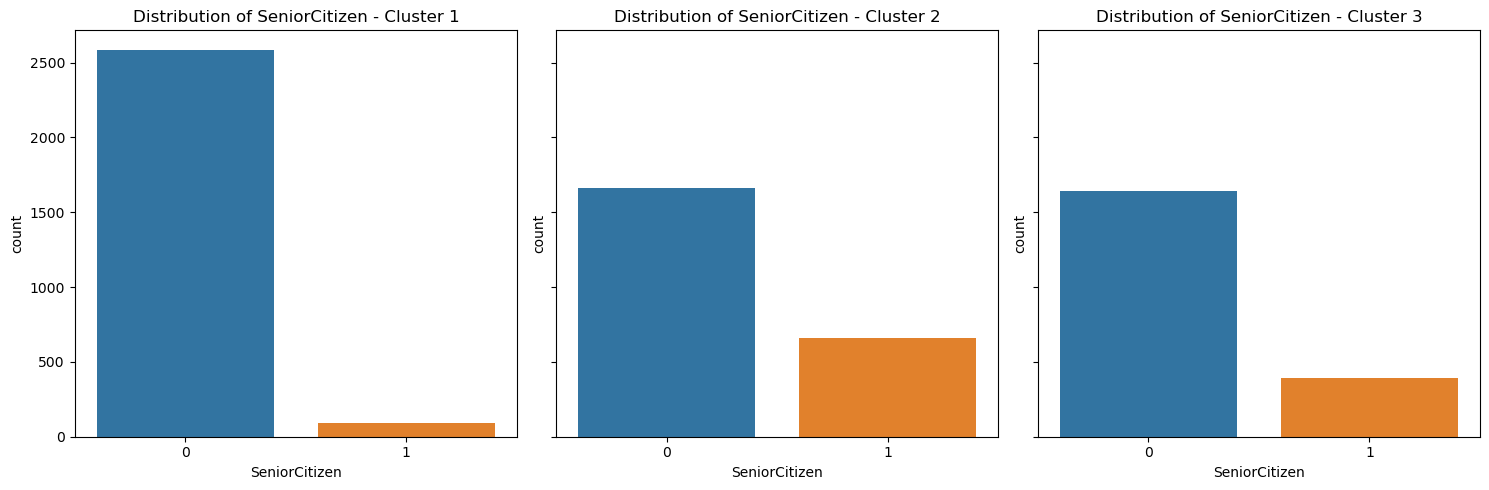

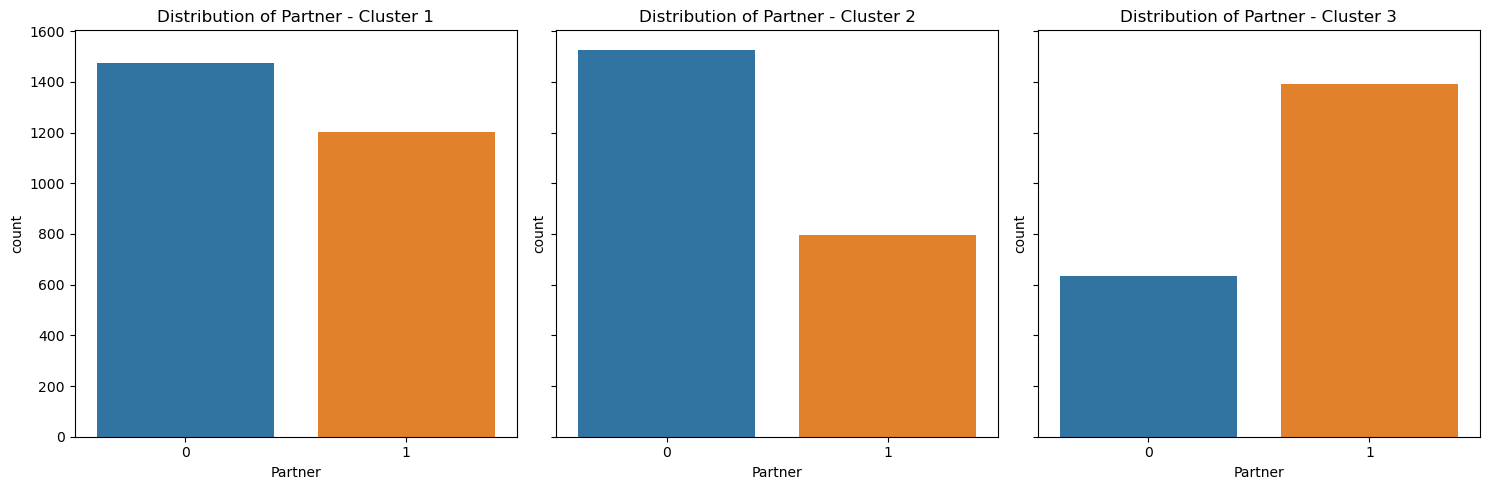

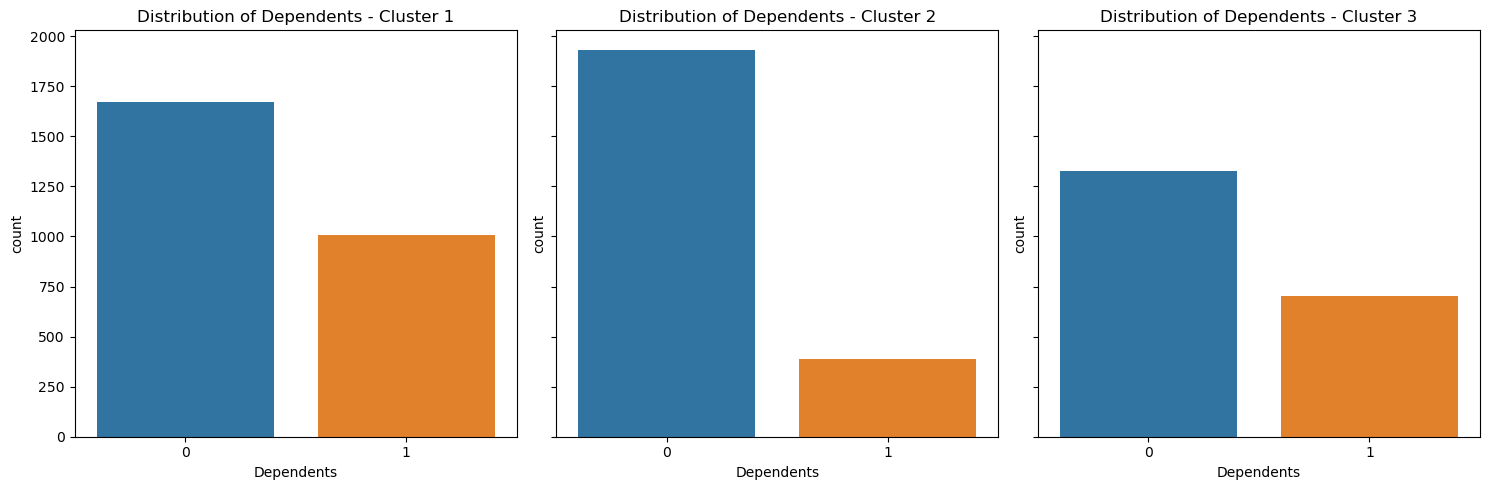

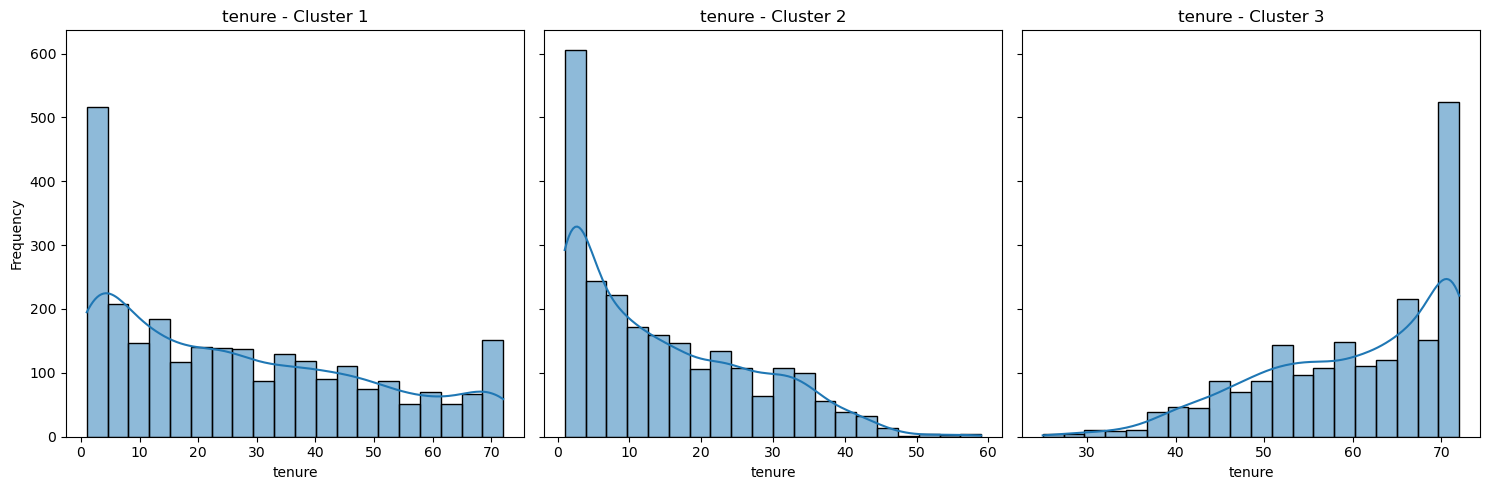

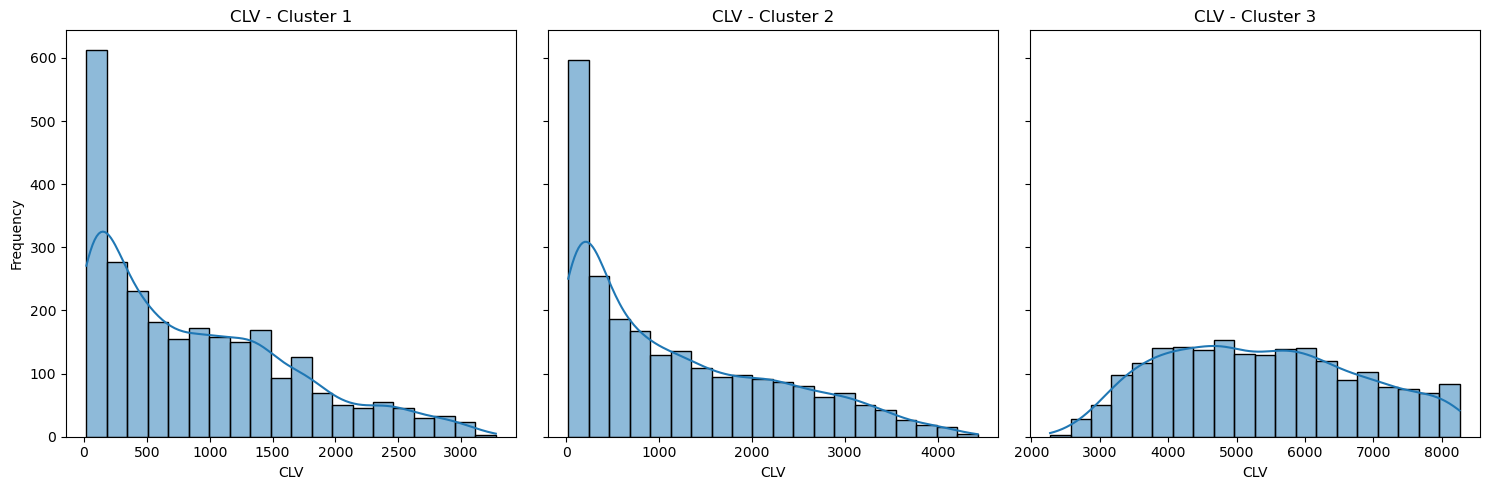

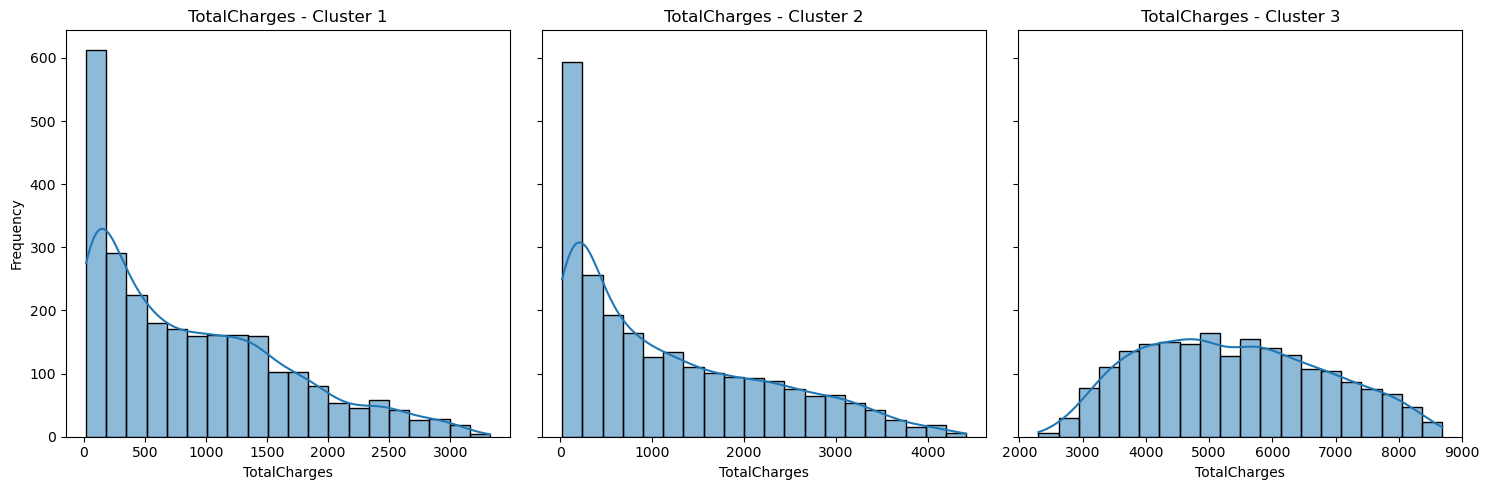

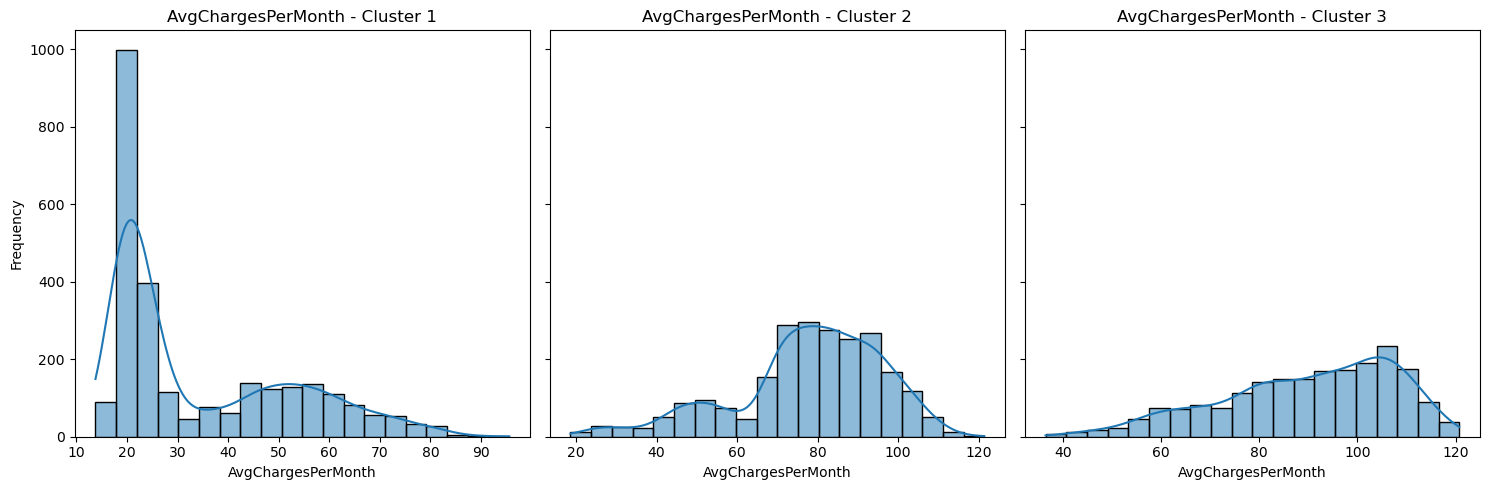

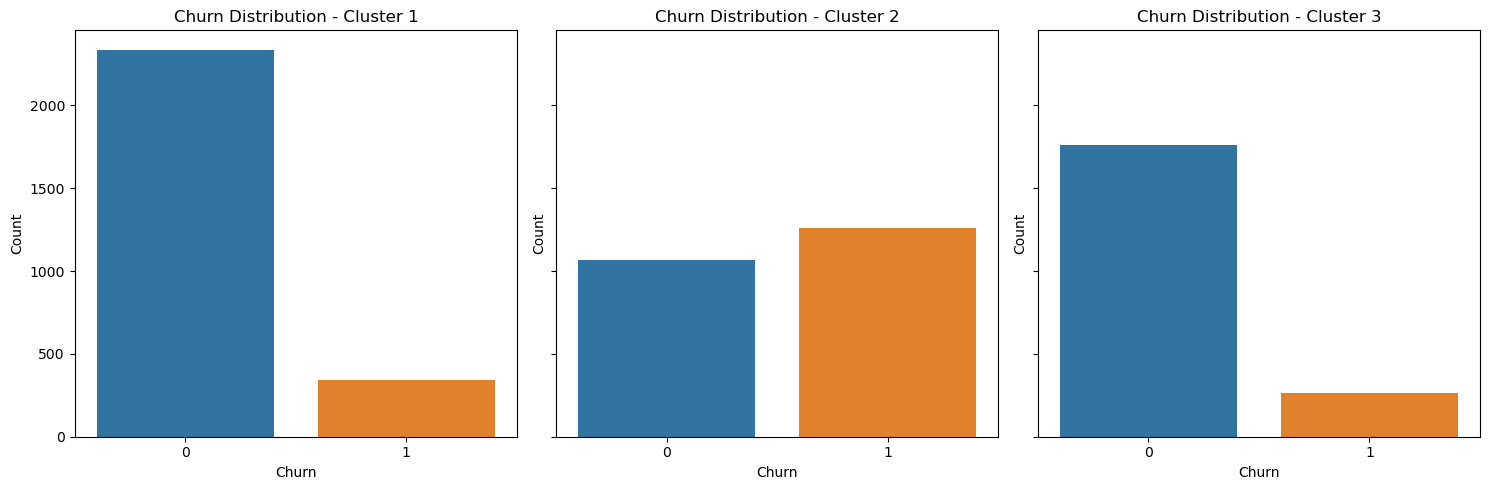

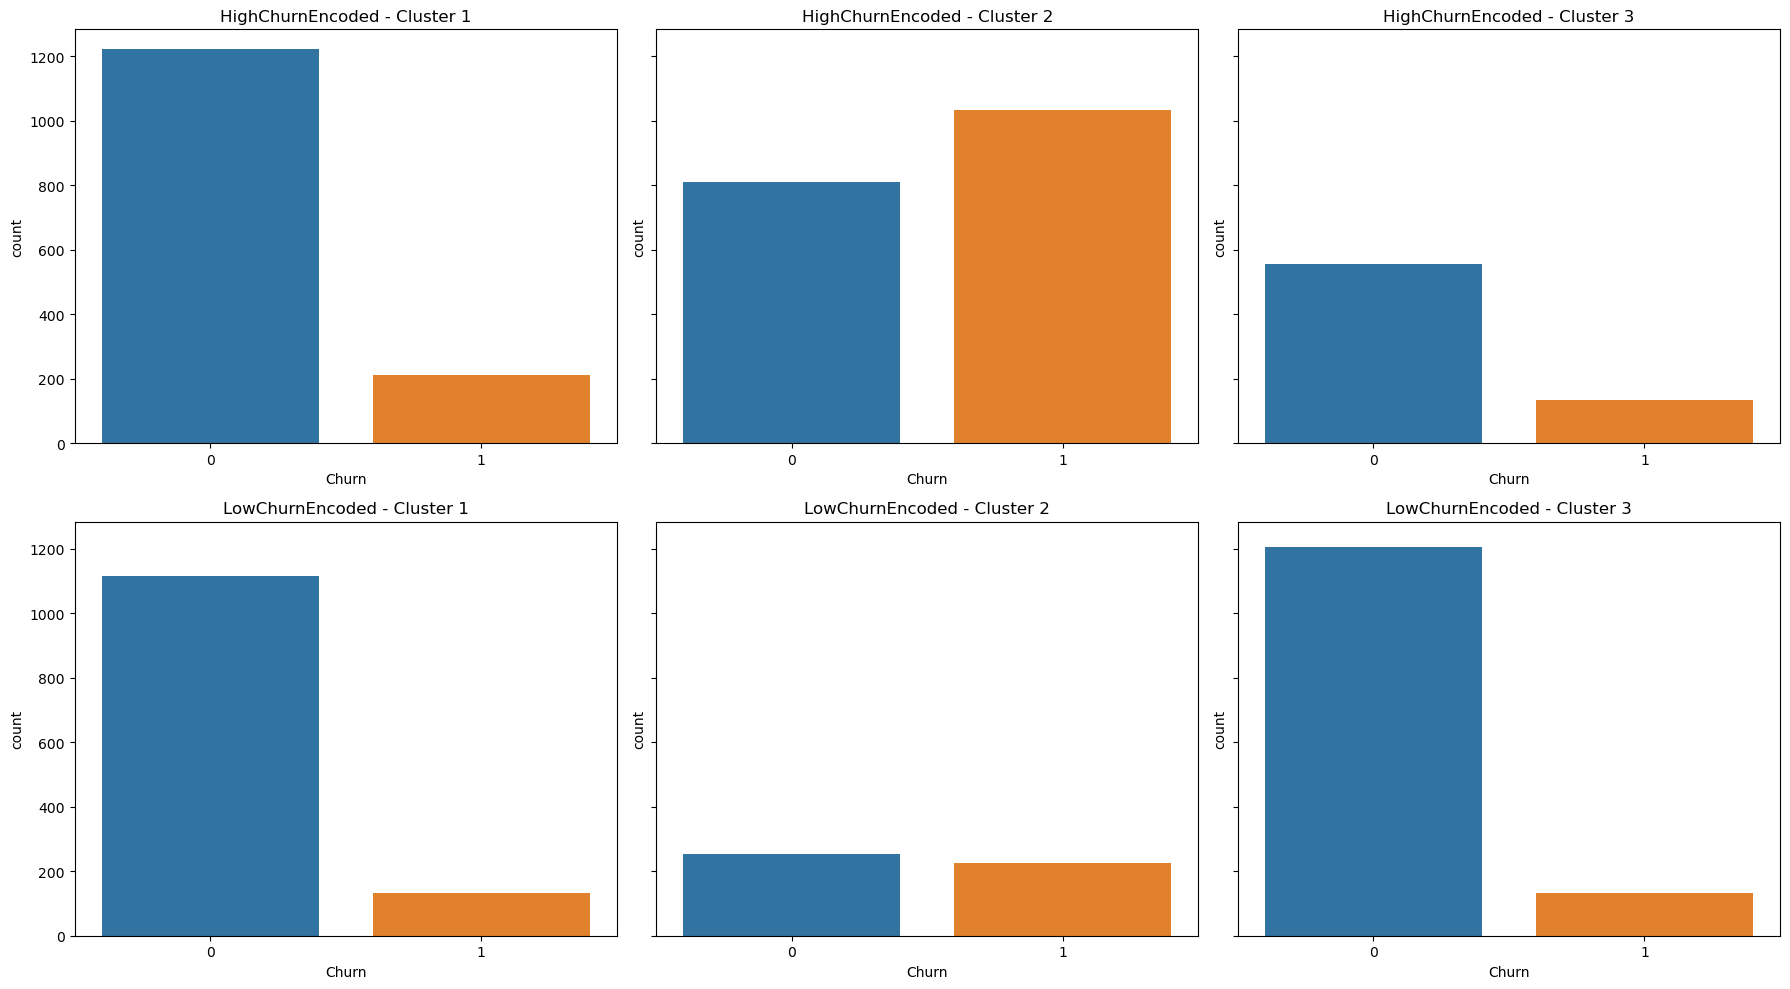

In [22]:
# Create cluster-wise datasets
clusts = {f'clust{i}': df[df['Cluster'] == i] for i in [1, 2, 3]}
data_list = list(clusts.values())

# -----------------------------
# Helper: Categorical Feature CountPlot per Cluster
# -----------------------------
def plot_categorical_by_cluster(feature, title_prefix="Distribution of"):
    fig, axes = plt.subplots(1, len(data_list), figsize=(15, 5), sharey=True)
    for i, data in enumerate(data_list):
        sns.countplot(x=feature, data=data, ax=axes[i])
        axes[i].set_title(f'{title_prefix} {feature} - Cluster {i + 1}')
        axes[i].set_xlabel(feature)
    plt.tight_layout()
    plt.show()

# Plot selected categorical features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
for feature in categorical_features:
    plot_categorical_by_cluster(feature)

# -----------------------------
# Helper: Numerical Feature HistPlot per Cluster
# -----------------------------
def plot_numerical_by_cluster(feature, bins=20):
    fig, axes = plt.subplots(1, len(data_list), figsize=(15, 5), sharey=True)
    for i, data in enumerate(data_list):
        sns.histplot(data[feature], kde=True, ax=axes[i], bins=bins)
        axes[i].set_title(f'{feature} - Cluster {i + 1}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot selected numerical features
numerical_features = ['tenure', 'CLV', 'TotalCharges', 'AvgChargesPerMonth']
for feature in numerical_features:
    plot_numerical_by_cluster(feature)

# -----------------------------
# Target Variable: Churn Distribution per Cluster
# -----------------------------
fig, axes = plt.subplots(1, len(data_list), figsize=(15, 5), sharey=True)
for i, data in enumerate(data_list):
    sns.countplot(x='Churn', data=data, ax=axes[i])
    axes[i].set_title(f'Churn Distribution - Cluster {i + 1}')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

# -----------------------------
# Churn by PaymentMethod (using churn-encoded version)
# -----------------------------
if 'PaymentMethod_churn_encoded' in df.columns:
    # Use median of encoded churn as threshold
    threshold = df['PaymentMethod_churn_encoded'].median()
    
    echeck_groups = {
        'HighChurnEncoded': df[df['PaymentMethod_churn_encoded'] >= threshold],
        'LowChurnEncoded': df[df['PaymentMethod_churn_encoded'] < threshold]
    }

    subgroups = {
        group: {f'Cluster {i}': g[g['Cluster'] == i] for i in [1, 2, 3]}
        for group, g in echeck_groups.items()
    }

    data_list_echeck = [
        {'data': subgroups[group][f'Cluster {i}'], 'title': f'{group} - Cluster {i}'}
        for group in subgroups for i in [1, 2, 3]
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.flatten()
    for ax, item in zip(axes, data_list_echeck):
        sns.countplot(x='Churn', data=item['data'], ax=ax)
        ax.set_title(item['title'])
    plt.tight_layout()
    plt.show()
else:
    print("Column 'PaymentMethod_churn_encoded' not found. Skipping eCheck-based churn plots.")